In [1]:
import yfinance as yf
import keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.rmsprop import RMSprop
import talib

In [2]:
data = yf.download('0700.hk')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-06-16,0.875,0.925,0.815,0.830,0.802119,2198875000
2004-06-17,0.830,0.875,0.825,0.845,0.816615,419007500
2004-06-18,0.840,0.850,0.790,0.805,0.777959,182990000
2004-06-21,0.820,0.825,0.790,0.800,0.773127,114085000
2004-06-22,0.800,0.800,0.800,0.800,0.773127,0


In [3]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [4]:
data['Prediction']=data['Close'].shift(-1)
data.drop('Adj Close',1,inplace=True)
data.dropna(inplace=True)
data.isnull().sum()

Open          0
High          0
Low           0
Close         0
Volume        0
Prediction    0
dtype: int64

In [5]:
data.head()

,Open,High,Low,Close,Volume,Prediction
Date,,,,,,
2004-06-16,0.875,0.925,0.815,0.830,2198875000,0.845
2004-06-17,0.830,0.875,0.825,0.845,419007500,0.805
2004-06-18,0.840,0.850,0.790,0.805,182990000,0.800
2004-06-21,0.820,0.825,0.790,0.800,114085000,0.800
2004-06-22,0.800,0.800,0.800,0.800,0,0.885


In [6]:
data_price=data["Prediction"]
train=data.drop("Prediction",1).values
sc = MinMaxScaler(feature_range=(0,1))
train=sc.fit_transform(train)
def processData(data,data_price,lb):
    X,Y = [],[]
    for i in range(lb-1,len(data)-lb-1):
        X.append(data[i-(lb-1):i])
        Y.append(data_price[(i)])
    return np.array(X),np.array(Y)

lb=7
X,y = processData(train,data_price,lb)
X_unseen=X[-30:]
X=X[:-30]
y_unseen=y[-30:]
y=y[:-30]
X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)].reshape(-1,1),y[int(y.shape[0]*0.90):].reshape(-1,1)
# print(type(X_train))
print(X.shape)
print(y.shape)

(4292, 6, 5)
(4292,)


In [7]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(3862, 6, 5) (3862, 1) (430, 6, 5) (430, 1)


In [8]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape= (X_train.shape[1], X_train.shape[2])))
model.add(Dense(50))
model.add(Dense(1))
model.compile(
  loss="mean_squared_error",
  optimizer='Adam'
)

In [9]:
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11200     
_________________________________________________________________
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 13,801
Trainable params: 13,801
Non-trainable params: 0
_________________________________________________________________


In [10]:
#Fit model with history to check for overfitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0)
history = model.fit(X_train,y_train,epochs=600,batch_size=20,validation_data=(X_test,y_test),shuffle=False)

Epoch 1/600
194/194 [==============================] - 10s 5ms/step - loss: 536.3586 - val_loss: 63118.8008
Epoch 2/600
194/194 [==============================] - 0s 2ms/step - loss: 25118.3623 - val_loss: 69962.2656
Epoch 3/600
194/194 [==============================] - 0s 2ms/step - loss: 304.6747 - val_loss: 46213.5664
Epoch 4/600
194/194 [==============================] - 0s 2ms/step - loss: 115.7045 - val_loss: 38096.0312
Epoch 5/600
194/194 [==============================] - 0s 3ms/step - loss: 92.5801 - val_loss: 35895.2969
Epoch 6/600
194/194 [==============================] - 0s 2ms/step - loss: 95.0651 - val_loss: 35281.2500
Epoch 7/600
194/194 [==============================] - 0s 2ms/step - loss: 87.2860 - val_loss: 35511.8008
Epoch 8/600
194/194 [==============================] - 0s 2ms/step - loss: 90.3738 - val_loss: 35892.3516
Epoch 9/600
194/194 [==============================] - 0s 2ms/step - loss: 93.4092 - val_loss: 36353.4258
Epoch 10/600
194/194 [=================

194/194 [==============================] - 0s 2ms/step - loss: 15.9456 - val_loss: 3995.5588
Epoch 154/600
194/194 [==============================] - 0s 2ms/step - loss: 14.3976 - val_loss: 4623.7178
Epoch 155/600
194/194 [==============================] - 0s 2ms/step - loss: 15.4234 - val_loss: 3988.9822
Epoch 156/600
194/194 [==============================] - 0s 2ms/step - loss: 16.6055 - val_loss: 4467.7041
Epoch 157/600
194/194 [==============================] - 0s 2ms/step - loss: 23.7458 - val_loss: 4578.9409
Epoch 158/600
194/194 [==============================] - 0s 2ms/step - loss: 23.9924 - val_loss: 4078.7229
Epoch 159/600
194/194 [==============================] - 1s 3ms/step - loss: 22.8372 - val_loss: 3709.6626
Epoch 160/600
194/194 [==============================] - 1s 3ms/step - loss: 21.7185 - val_loss: 3673.4192
Epoch 161/600
194/194 [==============================] - 0s 3ms/step - loss: 12.9744 - val_loss: 3766.1743
Epoch 162/600
194/194 [============================

Epoch 230/600
194/194 [==============================] - 0s 2ms/step - loss: 12.6749 - val_loss: 2529.2405
Epoch 231/600
194/194 [==============================] - 0s 2ms/step - loss: 15.6707 - val_loss: 2866.5291
Epoch 232/600
194/194 [==============================] - 0s 2ms/step - loss: 19.0764 - val_loss: 2492.3508
Epoch 233/600
194/194 [==============================] - 0s 2ms/step - loss: 21.5576 - val_loss: 2651.3494
Epoch 234/600
194/194 [==============================] - 0s 2ms/step - loss: 29.2568 - val_loss: 2882.8430
Epoch 235/600
194/194 [==============================] - 0s 2ms/step - loss: 23.2665 - val_loss: 3598.7449
Epoch 236/600
194/194 [==============================] - 0s 2ms/step - loss: 21.3500 - val_loss: 2755.3877
Epoch 237/600
194/194 [==============================] - 0s 2ms/step - loss: 20.2254 - val_loss: 2398.3582
Epoch 238/600
194/194 [==============================] - 0s 2ms/step - loss: 37.9243 - val_loss: 2365.8320
Epoch 239/600
194/194 [==============

Epoch 307/600
194/194 [==============================] - 0s 2ms/step - loss: 20.4675 - val_loss: 2273.2026
Epoch 308/600
194/194 [==============================] - 0s 2ms/step - loss: 11.7544 - val_loss: 2350.7227
Epoch 309/600
194/194 [==============================] - 0s 2ms/step - loss: 8.5004 - val_loss: 2538.8840
Epoch 310/600
194/194 [==============================] - 0s 2ms/step - loss: 11.5938 - val_loss: 1985.2812
Epoch 311/600
194/194 [==============================] - 1s 3ms/step - loss: 9.6444 - val_loss: 1929.3097
Epoch 312/600
194/194 [==============================] - 0s 2ms/step - loss: 9.5367 - val_loss: 2032.4248
Epoch 313/600
194/194 [==============================] - 0s 2ms/step - loss: 6.1328 - val_loss: 2082.4697
Epoch 314/600
194/194 [==============================] - 0s 2ms/step - loss: 5.9883 - val_loss: 2051.9771
Epoch 315/600
194/194 [==============================] - 0s 2ms/step - loss: 6.0450 - val_loss: 1987.5854
Epoch 316/600
194/194 [====================

Epoch 384/600
194/194 [==============================] - 1s 3ms/step - loss: 6.4972 - val_loss: 1884.4275
Epoch 385/600
194/194 [==============================] - 1s 3ms/step - loss: 5.3188 - val_loss: 1853.9921
Epoch 386/600
194/194 [==============================] - 0s 2ms/step - loss: 6.9240 - val_loss: 1836.5863
Epoch 387/600
194/194 [==============================] - 1s 3ms/step - loss: 9.0331 - val_loss: 1922.8737
Epoch 388/600
194/194 [==============================] - 0s 2ms/step - loss: 9.8238 - val_loss: 2174.7976
Epoch 389/600
194/194 [==============================] - 0s 2ms/step - loss: 9.5409 - val_loss: 2502.5828
Epoch 390/600
194/194 [==============================] - 0s 2ms/step - loss: 9.3446 - val_loss: 2905.6521
Epoch 391/600
194/194 [==============================] - 0s 2ms/step - loss: 10.1579 - val_loss: 3199.4524
Epoch 392/600
194/194 [==============================] - 0s 3ms/step - loss: 11.0856 - val_loss: 2121.8499
Epoch 393/600
194/194 [=====================

194/194 [==============================] - 0s 3ms/step - loss: 5.6217 - val_loss: 1807.1943
Epoch 539/600
194/194 [==============================] - 1s 3ms/step - loss: 5.4178 - val_loss: 1639.3381
Epoch 540/600
194/194 [==============================] - 0s 2ms/step - loss: 4.9581 - val_loss: 1622.4027
Epoch 541/600
194/194 [==============================] - 0s 2ms/step - loss: 4.6047 - val_loss: 1654.2462
Epoch 542/600
194/194 [==============================] - 0s 2ms/step - loss: 5.7651 - val_loss: 1663.9725
Epoch 543/600
194/194 [==============================] - 0s 2ms/step - loss: 5.0001 - val_loss: 1681.1906
Epoch 544/600
194/194 [==============================] - 0s 2ms/step - loss: 4.2707 - val_loss: 1703.3263
Epoch 545/600
194/194 [==============================] - 1s 3ms/step - loss: 5.2375 - val_loss: 1718.4789
Epoch 546/600
194/194 [==============================] - 0s 3ms/step - loss: 6.2875 - val_loss: 1722.9152
Epoch 547/600
194/194 [==============================] - 0s 

In [11]:
y_pred = model.predict(X_test)

In [12]:
y_pred.shape

(430, 1)

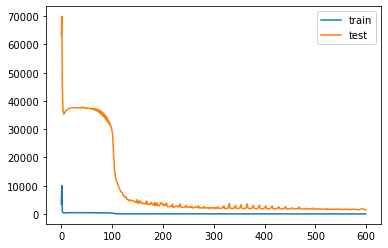

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

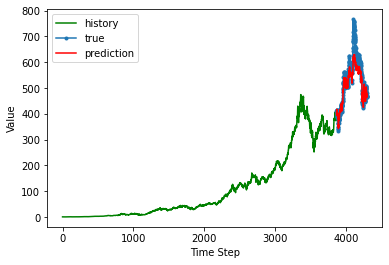

In [14]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [15]:
# plot_x=data[int(X.shape[0]*0.90):]
# plot_x["Prediction"]=y_test

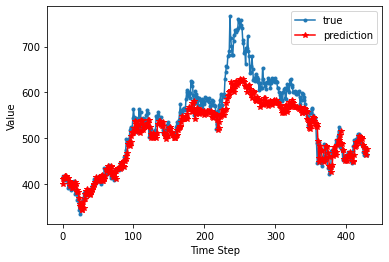

In [16]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [17]:
mean_absolute_percentage_error(y_test,y_pred)*100

4.625399638254628

In [18]:
mean_squared_error(y_test,y_pred)

1471.1840274846506

In [19]:
r2_score(y_test,y_pred)

0.827502876859856

In [20]:
y_pred_lstm_final = np.zeros((len(y_pred)-1,))
y_test_t_final = np.zeros((len(y_test)-1,))
for i in range(len(y_pred)-1):
    if y_pred[i+1] >= y_pred[i]:
        y_pred_lstm_final[i] = 1
    else:
        y_pred_lstm_final[i] = 0
        
#convert prediction into binary output (up or down movement)
for i in range(len(y_test)-1):
    if y_test[i+1] >= y_test[i]:
        y_test_t_final[i] = 1
    else:
        y_test_t_final[i] = 0


# error_lstm = mean_absolute_error(y_test_t_final, y_pred_lstm_final)
# print("Error is", error_lstm, y_pred_lstm_final.shape, y_test_t_final.shape)
print(y_pred_lstm_final[0:15])
print(y_test_t_final[0:15])
print("Predicted direction accuracy (Up/down):")
print(accuracy_score(y_test_t_final,y_pred_lstm_final))

[1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1.]
[1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1.]
Predicted direction accuracy (Up/down):
0.4568764568764569


In [21]:
print(y_test_t_final)

[1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1.
 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1.
 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0.
 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1.
 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1.
 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0.
 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1.
 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0.

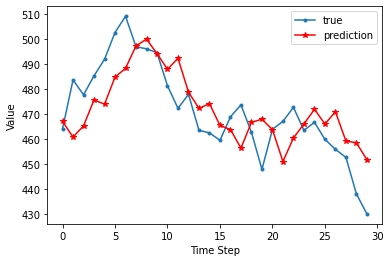

In [22]:
y_unseen_pred=model.predict(X_unseen)
plt.plot(y_unseen, marker='.', label="true")
plt.plot(y_unseen_pred, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [23]:
mean_absolute_percentage_error(y_unseen,y_unseen_pred)*100

2.241026709085729

In [24]:
mean_squared_error(y_unseen,y_unseen_pred)

164.64517106233785

In [25]:
r2_score(y_unseen,y_unseen_pred)

0.4963888326453061